In [1]:
from __future__ import annotations
from pathlib import Path
import numpy as np
from gpaw.lcao.tools import remove_pbc
from qtpyt.basis import Basis
from ase.io import read
from qtpyt.block_tridiag import graph_partition, greenfunction
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.tools import remove_pbc, rotate_couplings
from qtpyt.projector import ProjectedGreenFunction
from qtpyt.hybridization import Hybridization
from qtpyt.continued_fraction import get_ao_charge
from scipy.linalg import eigvalsh

from ase.io import read
import pickle

import os

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
data_folder = '../output/compute_run'
# Create the folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

H_subdiagonalized, S_subdiagonalized = np.load(f"{data_folder}/hs_los_lowdin.npy")
H_subdiagonalized = H_subdiagonalized.astype(np.complex128)
S_subdiagonalized = S_subdiagonalized.astype(np.complex128)

GPWDEVICEDIR = '../dft/device/'
GPWLEADSDIR = '../dft/leads/'

cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)

H_leads_lcao, S_leads_lcao = np.load(pl_path / 'hs_pl_k.npy')

basis_dict = {'Au': 9, 'H': 5, 'C': 13, 'N': 13}

leads_atoms = read(pl_path / 'leads.xyz')
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)

device_atoms = read(cc_path / 'scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis_dict)

In [3]:
nodes = [0,810,1116,1278,1584,2394]

# Define energy range and broadening factor for the Green's function calculation
de = 0.2
energies = np.arange(-3., 3. + de / 2., de).round(7)
eta = 1e-3

# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)

# Define parameters for matsubara grid
ne = 30
beta = 70.
matsubara_energies = 1.j * (2 * np.arange(ne) + 1) * np.pi / beta

In [4]:
# Prepare the k-points and matrices for the leads (Hamiltonian and overlap matrices)
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_subdiagonalized[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_subdiagonalized)
remove_pbc(device_basis, S_subdiagonalized)

# Initialize self-energy list for left and right leads
self_energy = [None, None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id='right')

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(nodes, H_subdiagonalized[0], S_subdiagonalized[0])
del H_subdiagonalized, S_subdiagonalized


In [13]:
self_energy[0].shape

(810, 810)

In [5]:
# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(hs_list_ii,
                                hs_list_ij,
                                [(0, self_energy[0]),
                                (len(hs_list_ii) - 1, self_energy[1])],
                                solver='dyson',
                                eta=eta)


# Define active region and the Green's function for the active region

index_active_region = np.load(f"{data_folder}/index_active_region.npy")

gfp = ProjectedGreenFunction(gf, index_active_region)
hyb = Hybridization(gfp)


n_A = len(index_active_region)
HB = np.empty((energies.size,n_A,n_A),dtype=complex)

for e, energy in enumerate(energies):
    HB[e] = hyb.retarded(energy)

filename = os.path.join(data_folder, 'hybridization.bin')
with open(filename,'wb') as f:
    HB.tofile(f)
del HB


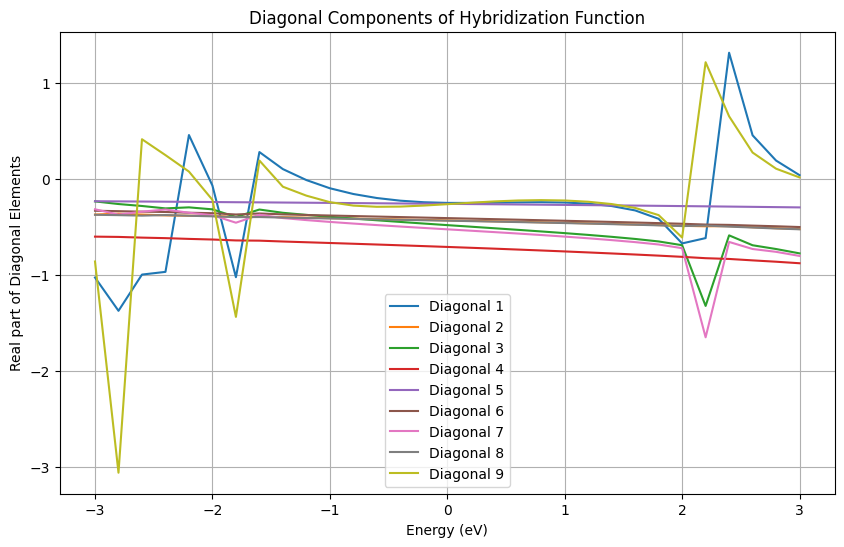

In [7]:
import numpy as np
import matplotlib.pyplot as plt

HB = np.fromfile(filename, dtype=complex).reshape((energies.size, n_A, n_A))

# Plot diagonal components of HB as a function of energy
plt.figure(figsize=(10, 6))

for i in range(n_A):
    diagonal_elements = np.real(HB[:, i, i])  # Extract real part of diagonal elements
    plt.plot(energies, diagonal_elements, label=f"Diagonal {i+1}")

plt.xlabel("Energy (eV)")
plt.ylabel("Real part of Diagonal Elements")
plt.title("Diagonal Components of Hybridization Function")
plt.legend()
plt.grid(True)
plt.show()

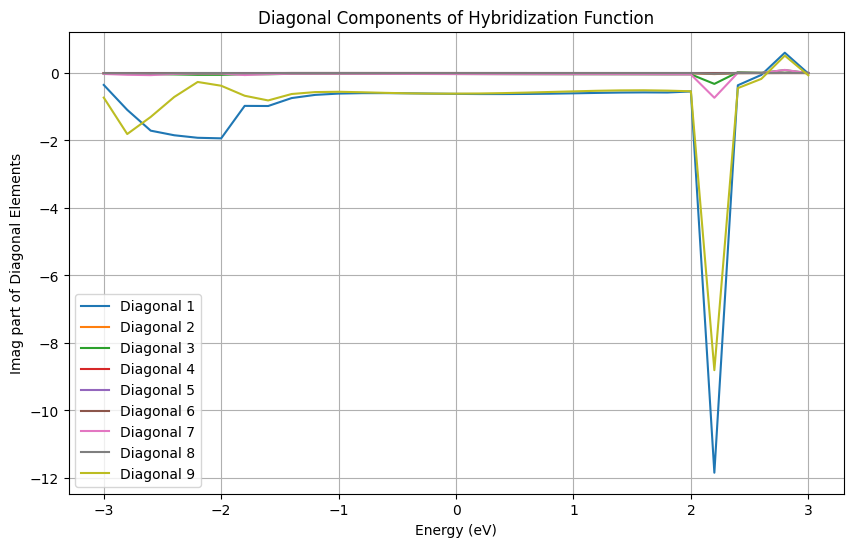

In [8]:
import numpy as np
import matplotlib.pyplot as plt

HB = np.fromfile(filename, dtype=complex).reshape((energies.size, n_A, n_A))

# Plot diagonal components of HB as a function of energy
plt.figure(figsize=(10, 6))

for i in range(n_A):
    diagonal_elements = np.imag(HB[:, i, i])  # Extract real part of diagonal elements
    plt.plot(energies, diagonal_elements, label=f"Diagonal {i+1}")

plt.xlabel("Energy (eV)")
plt.ylabel("Imag part of Diagonal Elements")
plt.title("Diagonal Components of Hybridization Function")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Matsubara
gf.eta = 0.
assert self_energy[0].eta == 0.
assert self_energy[1].eta == 0.

HB_mat = np.empty((matsubara_energies.size,n_A,n_A),dtype=complex)

for e, energy in enumerate(matsubara_energies):
    HB_mat[e] = hyb.retarded(energy)

# Save the Matsubara hybrid data
filename = os.path.join(data_folder, 'matsubara_hybridization.bin')
with open(filename,'wb') as f:
    HB_mat.tofile(f)
del HB_mat

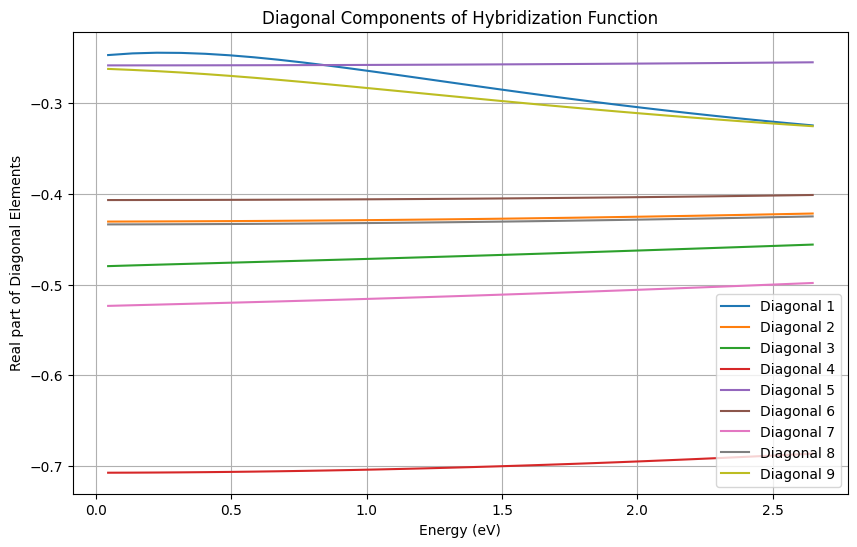

In [10]:
HB_mat = np.fromfile(filename, dtype=complex).reshape((matsubara_energies.size, n_A, n_A))

# Plot diagonal components of HB as a function of energy
plt.figure(figsize=(10, 6))

for i in range(n_A):
    diagonal_elements = np.real(HB_mat[:, i, i])  # Extract real part of diagonal elements
    plt.plot(np.imag(matsubara_energies), diagonal_elements, label=f"Diagonal {i+1}")

plt.xlabel("Energy (eV)")
plt.ylabel("Real part of Diagonal Elements")
plt.title("Diagonal Components of Hybridization Function")
plt.legend()
plt.grid(True)
plt.show()

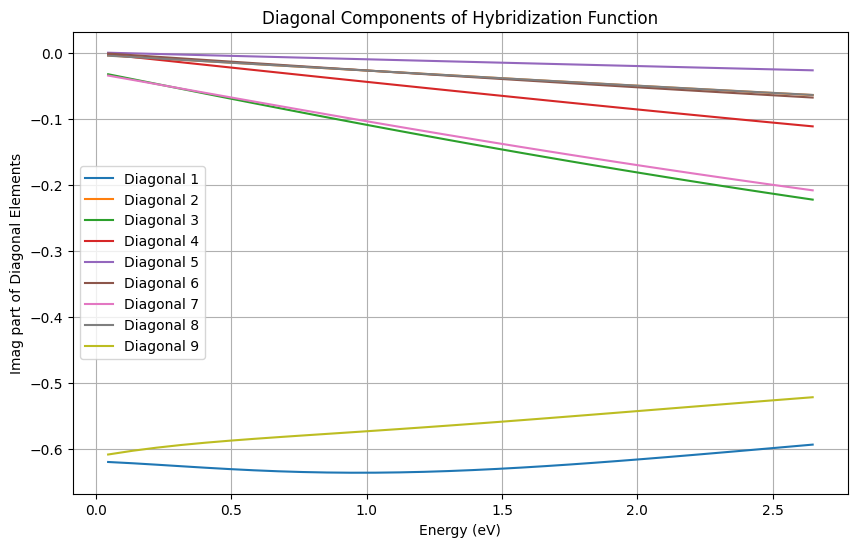

In [11]:
HB_mat = np.fromfile(filename, dtype=complex).reshape((matsubara_energies.size, n_A, n_A))

# Plot diagonal components of HB as a function of energy
plt.figure(figsize=(10, 6))

for i in range(n_A):
    diagonal_elements = np.imag(HB_mat[:, i, i])  # Extract real part of diagonal elements
    plt.plot(np.imag(matsubara_energies), diagonal_elements, label=f"Diagonal {i+1}")

plt.xlabel("Energy (eV)")
plt.ylabel("Imag part of Diagonal Elements")
plt.title("Diagonal Components of Hybridization Function")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
save_path = os.path.join(data_folder, 'hs_list_ii.pkl')
with open(save_path, 'wb') as f:
    pickle.dump(hs_list_ii, f)
save_path = os.path.join(data_folder, 'hs_list_ij.pkl')
with open(save_path, 'wb') as f:
    pickle.dump(hs_list_ij, f)

np.save(os.path.join(data_folder, 'energies.npy'), energies + 1.j * eta)
# Effective Hamiltonian
np.save(os.path.join(data_folder, 'hamiltonian.npy'), hyb.H)
np.save(os.path.join(data_folder, 'occupancies.npy'), get_ao_charge(gfp))
np.save(os.path.join(data_folder, 'matsubara_energies.npy'), matsubara_energies)

np.save(os.path.join(data_folder, 'self_energy.npy'), self_energy)
Heff = (hyb.H + hyb.retarded(0.)).real
np.save(os.path.join(data_folder, 'effective_hamiltonian.npy'), Heff)
np.save(os.path.join(data_folder, 'eigvals_Heff.npy'), eigvalsh(Heff, gfp.S))
